In [1]:
from multiprocessing import Process, Value
import EPUtils
import gdas
from datetime import datetime, timedelta
import numpy as np
import numpy.ma as ma
import scipy.optimize as opt
import matplotlib.pyplot as plt
import random
import copy
import pickle
import time
import math
from scipy.constants import *

# define constants

STATION_STANDARD_DEVIATIONS = {
    'berkeley02': 2.0,
    'berkeley01': 4.0,
    'daejeon01': 0.2,
    'hayward01': 0.1,
    'krakow01': 0.8,
    'lewisburg01': 0.1,
    'mainz01': 0.1,
    'losangeles01': 1.5,
    'moxa01': 1.0,
    'oberlin01': 0.2
}

STATION_SENSITIVE_AXES = { # in form: longitude, long direction?, lattitude, lat direction?, azimuth, altitude
    'beijing01': (116.1868,'E',40.2457,'N',251,0),
    'berkeley02': (122.2570,'W',37.8723,'N',0,90),
    'canberra01': (149.1185,'E',35.2745,'S',0,90),
    'daejeon01': (127.3987,'E',36.3909,'N',0,90),
    'hayward01': (122.0539,'W',37.6564,'N',0,90),
    'krakow01': (19.9048,'E',50.0289,'N',0,90),
    'lewisburg01': (76.8825,'W',40.9557,'N',0,90),
    'losangeles01': (118.4407,'W',34.0705,'N',270,0),
    'mainz01': (8.2354,'E',49.9915,'N',0,-90),
    'moxa01': (11.6147,'E',50.6450,'N',270,0),
    'oberlin01': (82.2204,'W', 41.2950,'N',276,0),
    'belgrade01': (20.3928,'E',44.8546,'N',300,0),
    'test01': (0,'E',0,'N',0,90),
    'test02': (45,'E',30,'N',0,90),
    'test03': (120,'W',45,'N',0,90),
    'test04': (83,'E',20,'N',0,90),
    'test05': (113,'W',45,'S',0,90),
    'test06': (20,'E',17,'S',0,90),
    'test07': (0,'E',90,'N',0,90) # aligned to +z axis
}

STATION_LIST =['test01','test02','test03','test04','test05','test06'] #'test','test','test','test','test','test','test','test']
# STATION_LIST = ['krakow01','hayward01','lewisburg01', 'mainz01', 'moxa01','daejeon01']
# STATION_LIST = ['lewisburg01', 'losangeles01', 'moxa01', 'oberlin01', 'mainz01','hayward01']
BANDWIDTH_LIMIT = 100 #Hz
FREQUENCY_SAMPLING_RATE = 512 #Hz
NUMBER_COINCIDENCE = 4
FREQUENCY_BIN_SIZE = 4 #Hz
FREQUENCY_TO_INJECT = 17 #Hz
LARGE_T_TILE = 256 # time tile width in s.
SMALL_T_TILE = 32 # time tile width in s.
SMALL_TILE_CUTOFF = 2 # number of additional tiles to cut off at the edge of signals.
PEAK_MIDPT = 1000 # midpoint of star crossing
# EXCESS_POWER_THRESHOLD = 

filepath = "../GNOMEDrive/gnome/serverdata/"
start_date = "2021-08-28-00-01-00"
window_length = 2048 # seconds
number_of_injections = 1
end_date = EPUtils.get_end_time(start_date, window_length)
min_time_seg_length = 1 # seconds
cartesian_axes, cartesian_coords = EPUtils.coord_transform(STATION_SENSITIVE_AXES)
## END OF USER DEFINED CONSTS ##

/home/stalnakerlab/AxionAnalysis/EPUtils.py:196: SyntaxWarning: invalid escape sequence '\D'
  fig.suptitle('{} {}: $\Delta$t = {} s. $\Delta$f = {} Hz.'.format(self.station,spectrogram, self.dt,self.df))
/home/stalnakerlab/anaconda3/envs/axion_env/lib/python3.12/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal
/home/stalnakerlab/anaconda3/envs/axion_env/lib/python3.12/site-packages/pykerr/qnm.py:2: UserWarning: pkg_re

In [2]:
# paralellizable FC data method
def fc_task(signal_list, cmask_small=None, cmask_big=None, skip=False):
    feldman = []
    feldman_sig = []
    feldman_unc = []
    task_signals = np.array(signal_list)
    for j in task_signals:
        print(j)
        total_passed_events = []
        total_sigs = []
        total_uncs = []
        for i in np.arange(number_of_injections):
            xtemp = random.uniform(-1, 1)
            ytemp = random.uniform(-1, 1)
            ztemp = random.uniform(-1, 1) 
            norm_factor = np.sqrt(xtemp**2 + ytemp**2 + ztemp**2)
            signal_vector_norm = [xtemp/norm_factor, ytemp/norm_factor, ztemp/norm_factor]   
            i_angle_offset = [random.uniform(-1, 1),random.uniform(-1, 1),random.uniform(-1, 1)]

            stat_obj_list: list[EPUtils.Station] = copy.deepcopy(STATION_OBJECT_LIST)
            
            # print(gen_mask)
            
            # injet signal
            for station in stat_obj_list:
                station: EPUtils.Station
                bounds = station.inject_signal(dir= [1,0,0],#signal_vector_norm, 
                                    fsamp=FREQUENCY_SAMPLING_RATE, 
                                    peak_start=1000,
                                    ampl=j, 
                                    vel=3e5, 
                                    radius=6e7,
                                    impact=0, 
                                    freq=FREQUENCY_TO_INJECT, 
                                    station_position=cartesian_coords[station.station], 
                                    station_axis=cartesian_axes[station.station], 
                                    impact_direction=i_angle_offset, 
                                    plot_signal=False,
                                    generate_mask=skip
                                    )
            
            if skip:               
                for station in stat_obj_list:
                    station.excess_power_init(FREQUENCY_SAMPLING_RATE, min_time_seg_length, BANDWIDTH_LIMIT, make_plot=False)
                    station.add_tiles(dt=LARGE_T_TILE,df=FREQUENCY_BIN_SIZE,verbose=False,)
                fp_frac, cmask_big = EPUtils.mask(ep_threshold,stat_obj_list,NUMBER_COINCIDENCE,0,make_plot=False, type='spec')

                
                for station in stat_obj_list:
                    station.excess_power_init(FREQUENCY_SAMPLING_RATE, min_time_seg_length, BANDWIDTH_LIMIT, make_plot=False)
                    station.add_tiles(dt=SMALL_T_TILE,df=FREQUENCY_BIN_SIZE,verbose=False,)
                fp_frac, cmask_small = EPUtils.mask(ep_threshold,stat_obj_list,NUMBER_COINCIDENCE,0,make_plot=False, type='spec')
                print('generated consistency masks')
                if skip:
                    return cmask_big, cmask_small, bounds
                continue
                
            for station in stat_obj_list:
                station.excess_power_init(FREQUENCY_SAMPLING_RATE, min_time_seg_length, BANDWIDTH_LIMIT, make_plot=True)
                station.add_tiles(dt=256,df=FREQUENCY_BIN_SIZE,verbose=False,)
                # print(station.spec_normal_summed.shape)
                
            fp_frac, mask = EPUtils.mask(ep_threshold,stat_obj_list,NUMBER_COINCIDENCE,4,make_plot=True, type='spec')
            # plotting
            for station in stat_obj_list:
                station.plot_spectrogram('spec_normal_summed')
            stat,xind,yind,mlist,x2list,passed_events, adj_signals, uncertanties = EPUtils.consistency_sum(stat_obj_list,mask,cartesian_axes,ep_threshold,verbose=False, guess=signal_vector_norm, dt=SMALL_T_TILE, cmask_big=cmask_big,cmask_small=cmask_small)
            total_passed_events.append(passed_events)
            total_sigs.append(adj_signals)
            total_uncs.append(uncertanties)
            # print(passed_events)
            # print(i)
            
        
        # save_data.save_dist(total_passed_events,str(j))
        # save_data.save_dist(total_sigs,str(j)+'sig')
        # save_data.save_dist(total_uncs,str(j)+'unc')
        feldman.append(total_passed_events)
    pass

Loading from filepath:  ../GNOMEDrive/gnome/serverdata/
10000000.0
generated consistency masks
10000000000.0


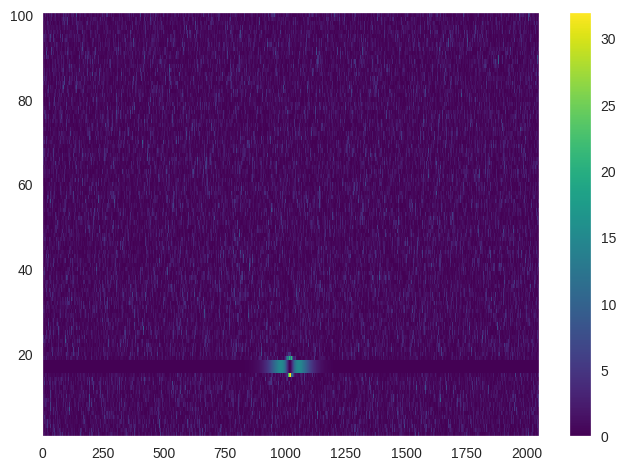

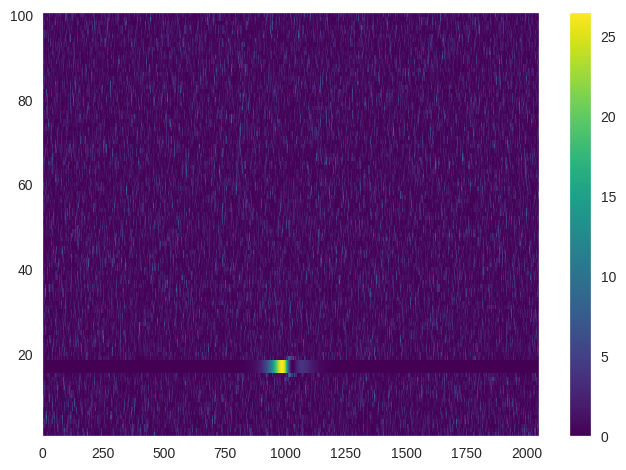

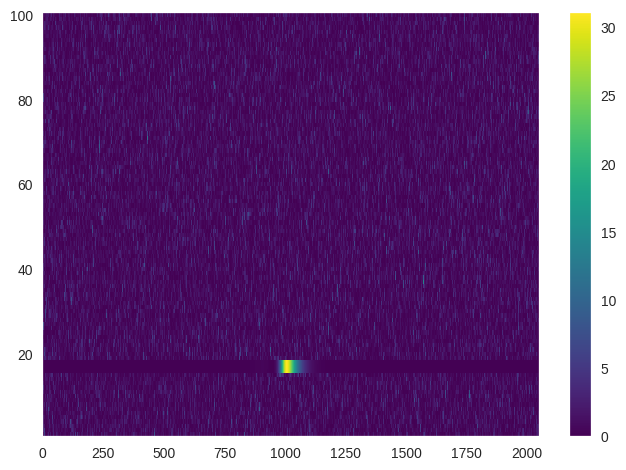

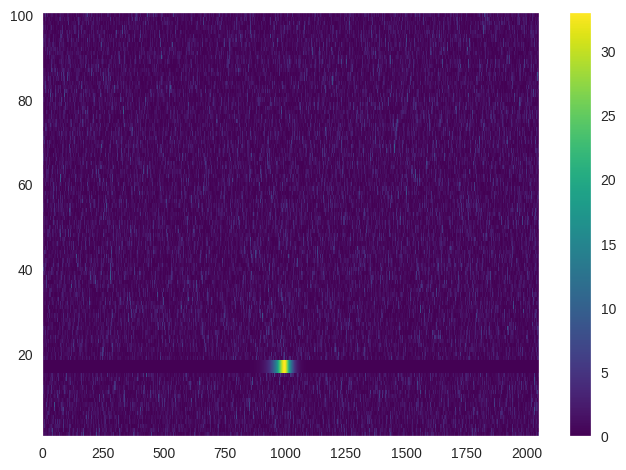

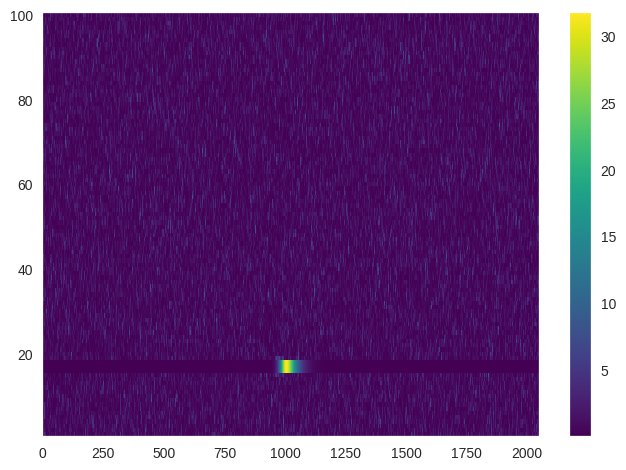

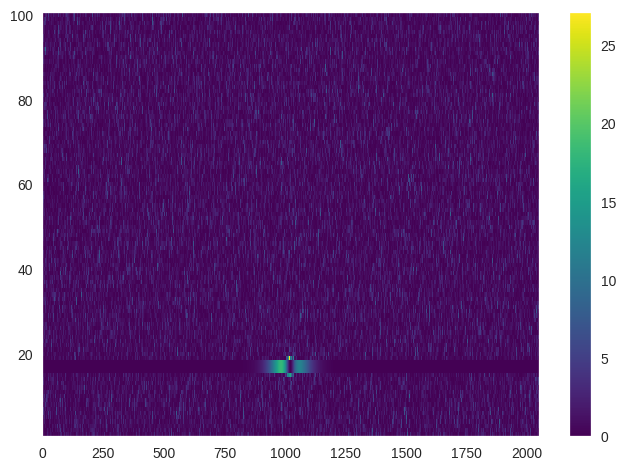

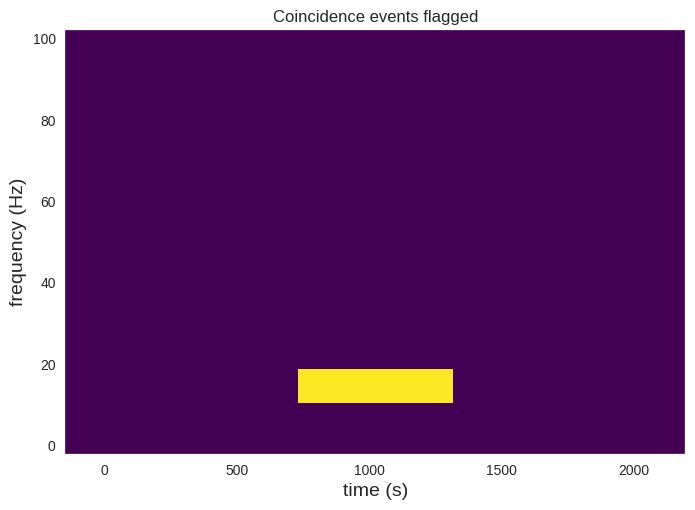

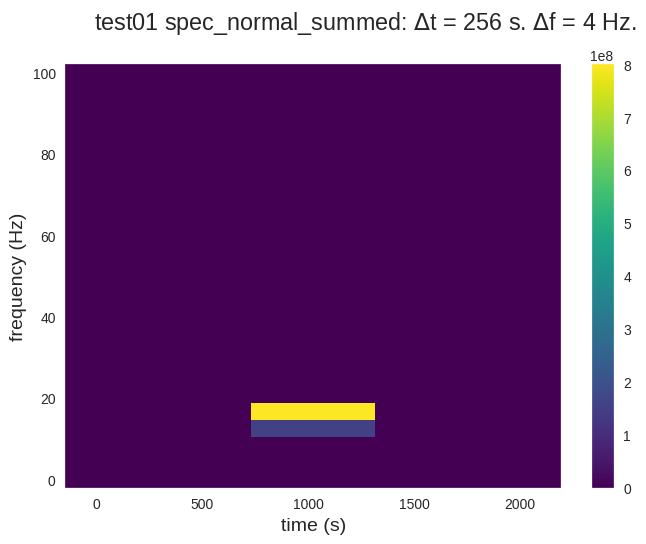

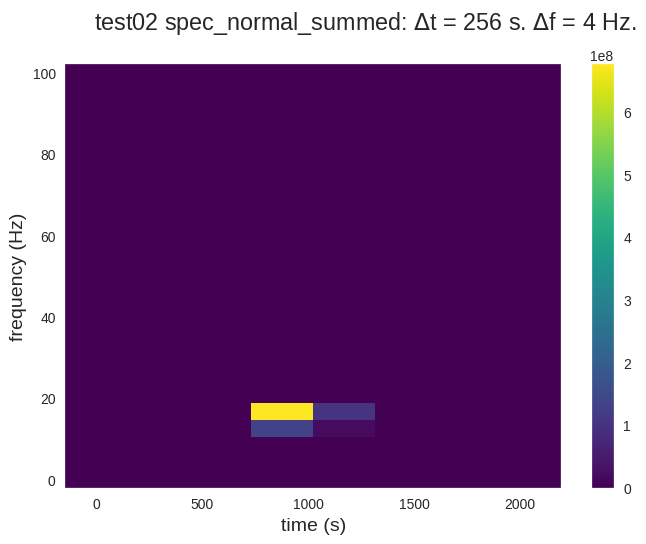

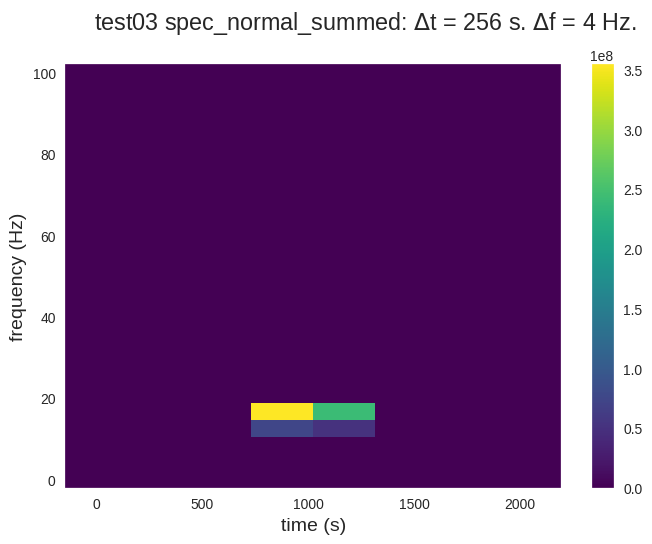

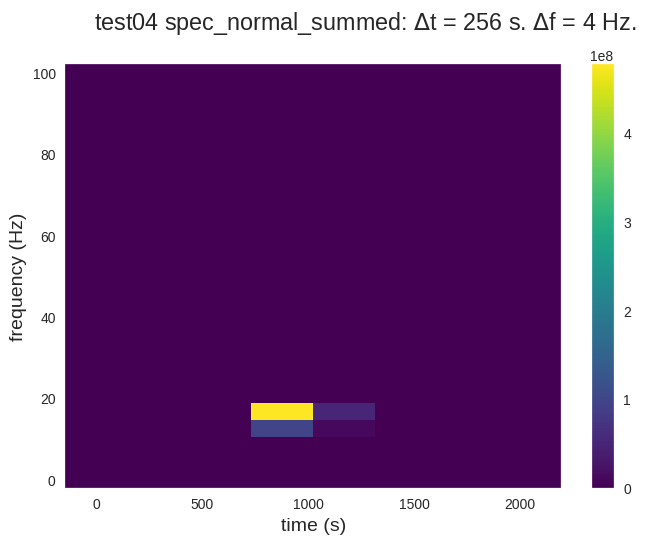

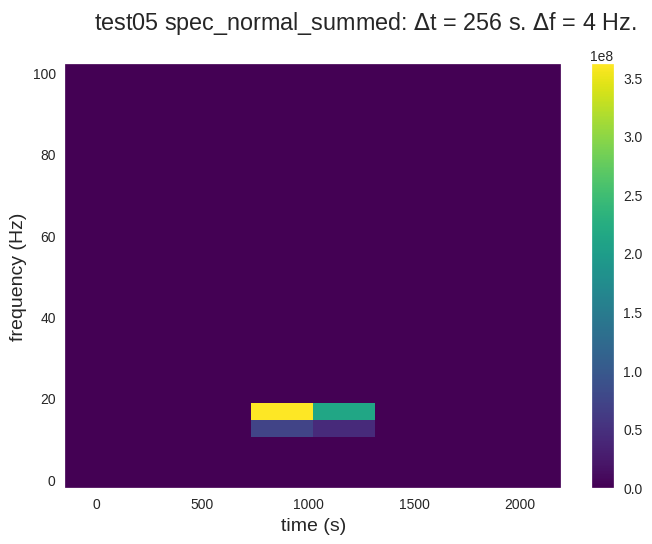

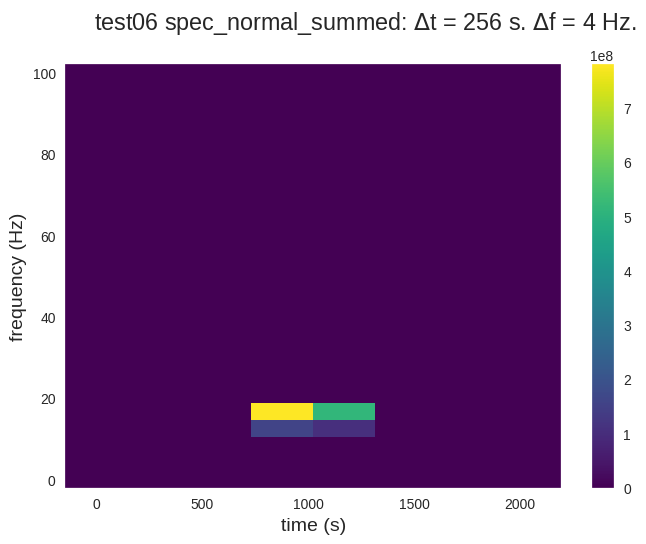

fc completed.


In [4]:
## DEFINE CONSTANTS ##
signals = np.linspace(1e7,1e10,40) # signal amplitude list for gausian background
# signals = np.linspace(1e3,1e7,40) # signal amplitude list for actual background data
ep_threshold = 3450 # excess power threshold
run_name = 'test' # naming instance of files to save

## LOAD FILES, NO INJECTION ##
sta_times,data_list, sanity_list, station_arr, starts, ends, STATION_OBJECT_LIST, bds = EPUtils.load_data(start_date, end_date, STATION_LIST, STATION_STANDARD_DEVIATIONS, FREQUENCY_SAMPLING_RATE,
                                                                                                filepath=filepath,
                                                                                                shift_time=None,
                                                                                                burst_ampl=3e14,
                                                                                                burst_freq=17,
                                                                                                burst_dur=256,
                                                                                                burst_start=500,
                                                                                                station_axes=None, # specify cartesian_axes if injecting, None else
                                                                                                station_positions=cartesian_coords,
                                                                                                signal_vec=[1,0,0],
                                                                                                velocity=3e5,
                                                                                                impact=0.5,
                                                                                                i_angle=[1,0,0],
                                                                                                radius=6e7,
                                                                                                verbose=True
                                                                                                )
# initialize save data utility
# save_data = EPUtils.DataUtils(run_name, signal_list=signals)

# initialize masks for consistency check
cmask_big = np.array([])
cmask_small = np.array([])
cmask_big, cmask_small, bounds = fc_task([signals[0]],None,None,True)
inj_f_tile = 100//FREQUENCY_BIN_SIZE
fmin = (FREQUENCY_TO_INJECT-1) // FREQUENCY_BIN_SIZE
fmax = math.ceil((FREQUENCY_TO_INJECT+1)/ FREQUENCY_BIN_SIZE)

cmask_big = np.zeros(shape=cmask_big.shape)
cmask_big[fmin-1:fmax, math.ceil(bounds[0]/ LARGE_T_TILE)-1:int(bounds[1]//LARGE_T_TILE)+1] = 1
cmask_small = np.zeros(shape=cmask_small.shape)
cmask_small[fmin-1:fmax, math.ceil(bounds[0]/ SMALL_T_TILE)-1+SMALL_TILE_CUTOFF:int(bounds[1]//SMALL_T_TILE)+1-SMALL_TILE_CUTOFF] = 1 # missing +1 in last bound to slightly restrict amt of tiles to analyze


proc_list = [] # list of running processes

fc_task([1e10],cmask_small, cmask_big)

# # begin and run a new process for each signal intensity
# for i, signal in enumerate(signals):
#     proc = Process(target=fc_task, args=([signal],cmask_small,cmask_big,))
#     proc_list.append(proc)
#     proc.start()
    
# # wait for each process to finish running
# for i, process in enumerate(proc_list):
#     process.join()

print("fc completed.")
    